### Solve IK for `Common Rig`

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.6]


### Parse `scene_common_rig.xml`

In [2]:
xml_path = '../asset/common_rig/scene_common_rig.xml'
env = MuJoCoParserClass(name='Common Rig',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0050] HZ:[200]
n_dof (=nv):[41]
n_geom:[26]
geom_names:['floor', 'base', 'root2spine', 'spine2neck', 'neck2rshoulder', 'neck2lshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rthumb', 'rpalm', 'lshoulder2lelbow', 'lelbow2lwrist', 'lthumb', 'lpalm', 'head', 'nose', 'base2rpelvis', 'rpelvis2rknee', 'rknee2rankle', 'rankle', 'rfoot', 'base2lpelvis', 'lpelvis2lknee', 'lknee2lankle', 'lankle', 'lfoot']
n_body:[20]
body_names:['world', 'base', 'torso', 'spine', 'neck', 'right_shoulder', 'right_elbow', 'right_hand', 'left_shoulder', 'left_elbow', 'left_hand', 'head', 'right_leg', 'right_pelvis', 'right_knee', 'right_ankle', 'left_leg', 'left_pelvis', 'left_knee', 'left_ankle']
n_joint:[36]
joint_names:['base', 'root1', 'root2', 'root3', 'spine', 'rs1', 'rs2', 'rs3', 're', 'rw1', 'rw2', 'rw3', 'ls1', 'ls2', 'ls3', 'le', 'lw1', 'lw2', 'lw3', 'head1', 'head2', 'head3', 'rp1', 'rp2', 'rp3', 'rk', 'ra1', 'ra2', 'ra3', 'lp1', 'lp2', 'lp3', 'lk', 'la1', 'la2', 'la3']
joint_types:[0 3 3 3 3 3 3

### Loop

Pressed ESC
Quitting.


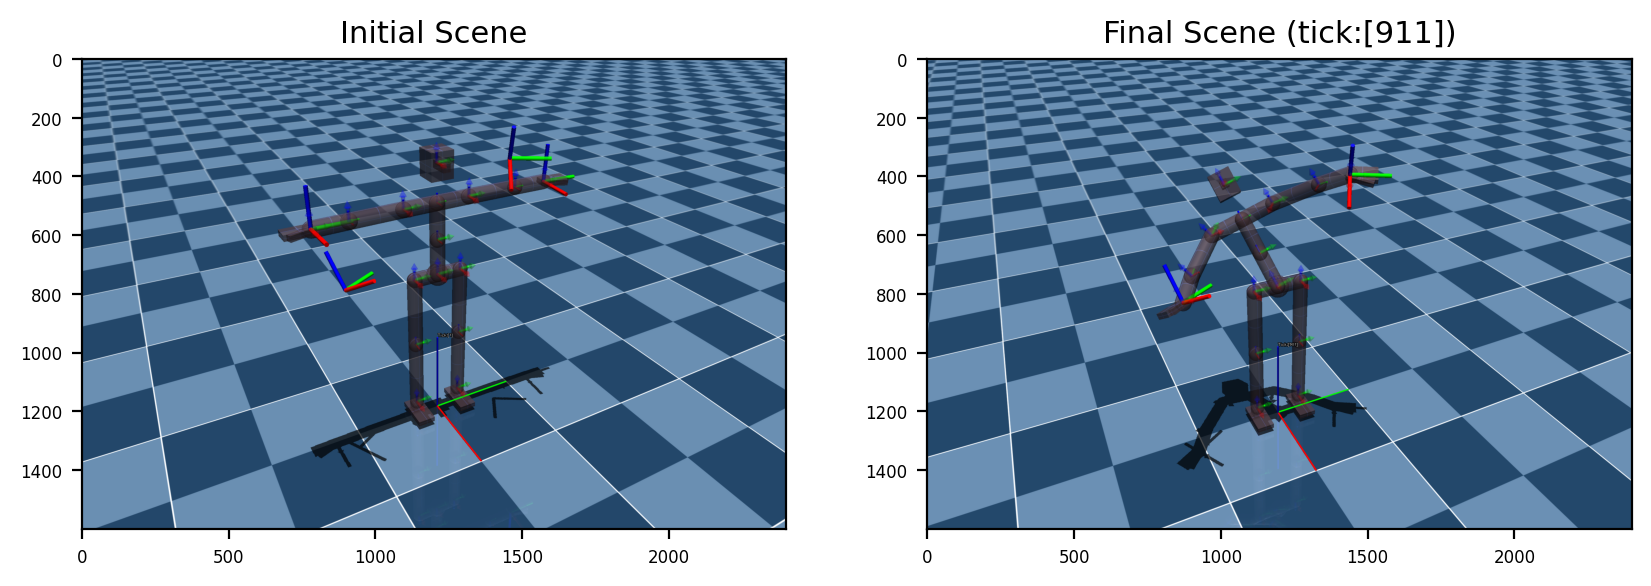

In [3]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Common Rig',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])

# Set which joints to control
rev_joint_names = env.rev_joint_names
joint_idxs_fwd = [env.model.joint(jname).qposadr[0] for jname in rev_joint_names]
joint_idxs_jac  = [env.model.joint(jname).dofadr[0] for jname in rev_joint_names]
q_rev_init = env.get_qpos_joints(rev_joint_names)
n_rev_joint = len(rev_joint_names)

# Set IK targets
ik_body_names,ik_p_trgts,ik_R_trgts = [],[],[]
# IK target 1
ik_body_name = 'right_hand'
p_curr,R_curr = env.get_pR_body(body_name=ik_body_name)
ik_p_trgt = p_curr+np.array([0.1,0.1,-0.3])
ik_R_trgt = rpy2r(np.radians([0,-30,30]))@R_curr
ik_body_names.append(ik_body_name)
ik_p_trgts.append(ik_p_trgt)
ik_R_trgts.append(ik_R_trgt)
# IK target 2
ik_body_name = 'left_hand'
p_curr,R_curr = env.get_pR_body(body_name=ik_body_name)
ik_p_trgt = p_curr+np.array([0.1,-0.3,0.2])
ik_R_trgt = rpy2r(np.radians([0,30,-30]))@R_curr
ik_body_names.append(ik_body_name)
ik_p_trgts.append(ik_p_trgt)
ik_R_trgts.append(ik_R_trgt)

# Reset and loop
q = q_rev_init.copy()
env.reset()
FIRST_FLAG = True
while env.is_viewer_alive():
    
    # Solve inverse kinematics
    J_list,ik_err_list = [],[]
    for ik_idx,ik_body_name in enumerate(ik_body_names):
        ik_p_trgt = ik_p_trgts[ik_idx]
        ik_R_trgt = ik_R_trgts[ik_idx]
        J,ik_err = env.get_ik_ingredients(
            body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
            IK_P=True,IK_R=True)
        J_list.append(J)
        ik_err_list.append(ik_err)
    J_stack      = np.vstack(J_list)
    ik_err_stack = np.hstack(ik_err_list)
    
    dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
    q = q + dq[joint_idxs_jac]
    
    # FK
    env.forward(q=q,joint_idxs=joint_idxs_fwd,INCREASE_TICK=True)
    
    if env.loop_every(tick_every=10):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        
        # Text information
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3),PLOT_AXIS=False,
                   label='Tick:[%d]'%(env.tick))
        
        # Plot bodies
        for body_name in env.body_names:
            p,R = env.get_pR_body(body_name=body_name)
            env.plot_T(p=p,R=R,PLOT_AXIS=True,axis_len=0.05,axis_width=0.005)
            
        # Plot IK target
        for ik_idx,ik_body_name in enumerate(ik_body_names):
            ik_p_trgt = ik_p_trgts[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            env.plot_body_T(body_name=ik_body_name,
                            PLOT_AXIS=True,axis_len=0.2,axis_width=0.01)
            env.plot_T(p=ik_p_trgt,R=ik_R_trgt,
                       PLOT_AXIS=True,axis_len=0.2,axis_width=0.01)
        
        # Plot revolute joints with arrow
        for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
            axis_joint = env.model.jnt_axis[rev_joint_idx]
            p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
            axis_world = R_joint@axis_joint
            axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
            axis_len,axis_r = 0.1,0.01
            env.plot_arrow_fr2to(
                p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
                r=axis_r,rgba=axis_rgba)
            
        # Plot contact information
        env.plot_contact_info(h_arrow=0.3,rgba_arrow=[1,0,0,1],
                              PRINT_CONTACT_BODY=False)
        env.render()
        
    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
    if env.is_viewer_alive() and env.loop_every(tick_every=100):
        scene_img_final = env.grab_image()
    FIRST_FLAG = False
        
# Close MuJoCo viewer
env.close_viewer()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()